In [1]:
import numpy as np
from matplotlib.pyplot import *
from spectral import imshow, view_cube
import spectral.io.envi as envi
from skimage import io
%matplotlib inline

In [2]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

In [4]:
sample_image = io.imread(r'D:/Data/Data_HSI/CRAS-Dia2/Sample Images/santonio.jpeg')

In [75]:
fpath = r'D:/Data/Data_HSI/CRAS-Dia2/Transmitancia/'
fname_ref = r'2 -  Santo Antonio/conversion_output/post_processing/santo_antonio_dark_current_compensation_radiometric_correction'
fnam_white = r'1 - Referencia Branco/conversion_output/post_processing/ref_branco_dark_current_compensation_radiometric_correction'

In [76]:
ref = envi.open(fpath + fname_ref + '.hdr', fpath + fname_ref + '.img')
white = envi.open(fpath + fnam_white + '.hdr', fpath + fnam_white + '.img')
data_nparr = np.array(ref.load())[:, 360:630, :]
data_white = np.array(white.load())[250:900, 360:630, :].mean(axis = (0))

In [77]:
corrected_nparr = data_nparr/data_white
bands = np.array(ref.bands.centers)

In [78]:
specim_fps = 1/(15e-3)
stage_speed = 10e-3

In [79]:
data_reg = corrected_nparr[150:1000]
y_size = data_reg.shape[0]/specim_fps*stage_speed * 1e2 #cm
x_size = 0.145 * 1e2 #cm

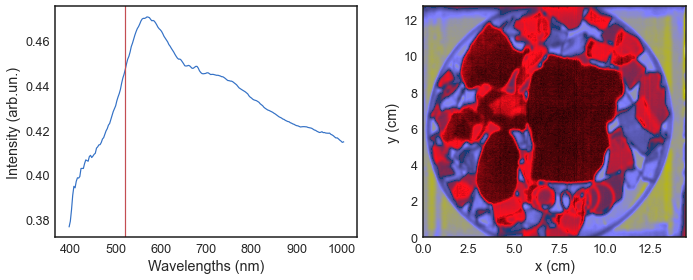

In [107]:
fig, ax = subplots(1, 2, figsize = (10, 4))

wl = 520 #450

axs = ax[0]
axs.plot(bands, data_reg.mean(axis = (0, 1)))
axs.axvline(wl, color = 'r')
axs.set_xlabel('Wavelengths (nm)')
axs.set_ylabel('Intensity (arb.un.)')
axs.grid(False)

axs = ax[1]
axs.imshow(data_reg[:, :, find_index(wl, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.grid(False)
axs.set_xlabel('x (cm)')
axs.set_ylabel('y (cm)')

fig.tight_layout()

In [102]:
boi = [650, 520, 450]
from skimage.filters import unsharp_mask

def make_rgb(bands_of_interest, sharpen = False):
    red, green, blue = bands_of_interest
    rgb_image = np.stack([data_reg[:, :, find_index(red, bands)], 
                          data_reg[:, :, find_index(green, bands)],
                          data_reg[:, :, find_index(blue, bands)]], axis = 2)
    if sharpen == True:
        return unsharp_mask(rgb_image, radius = 10, amount = 1)
    else:
        return rgb_image

img_boi = make_rgb(boi)

In [130]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

data_kmeans = img_boi.reshape(img_boi.shape[0]*img_boi.shape[1], -1)
scaled = MinMaxScaler().fit_transform(data_kmeans)

model = GaussianMixture(n_components = 5)
model.fit(scaled)
labels = model.predict(scaled).reshape(img_boi.shape[:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


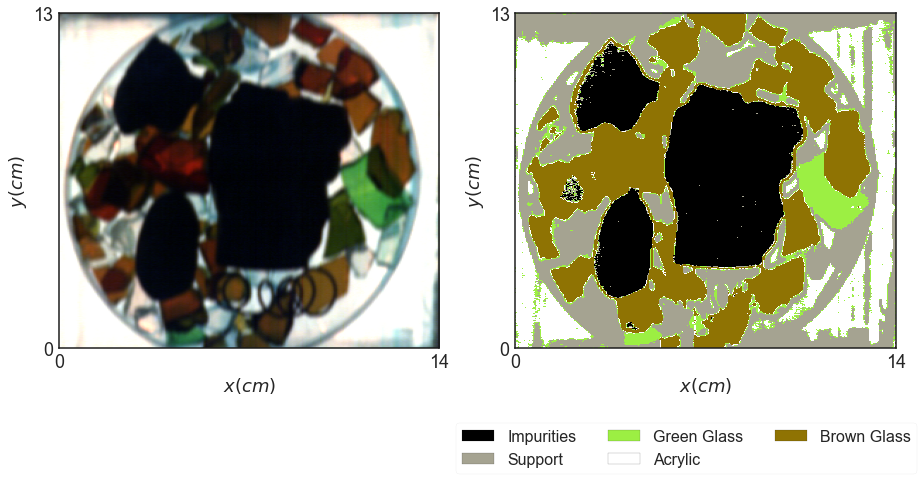

In [167]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
fig, ax = subplots(1, 2, figsize = (15, 7))

colors = ["xkcd:black", "xkcd:cement", "xkcd:kiwi", "xkcd:white", "xkcd:poo"]
name_list = ["Impurities", "Support", "Green Glass", "Acrylic", "Brown Glass"]
cmap = ListedColormap(colors)

hls = []
for color, cluster in zip(colors, name_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

# ax.set_title('Unsupervised Classification Results')

axs = ax[0]
axs.imshow(img_boi[::, ::-1], extent = (0, x_size, 0, y_size))
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)

axs = ax[1]
axs.imshow(labels[::, ::-1], extent = (0, x_size, 0, y_size), cmap = cmap)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)
axs.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (0.45, -0.4), ncol = 3, fontsize = 16)

# savefig("Images/clustering.jpg", dpi = 300, bbox_inches = 'tight')

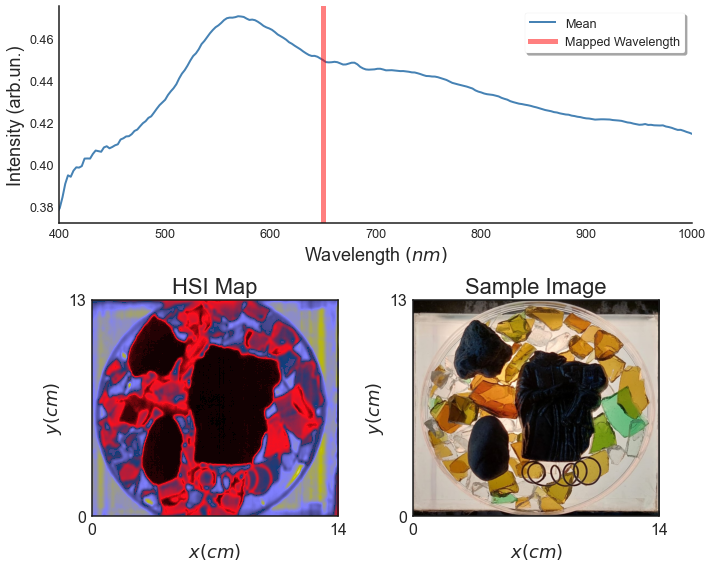

In [112]:
from matplotlib import gridspec

from mpl_toolkits.axes_grid1.inset_locator import mark_inset

matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.edgecolor'] = '0.1'

fig = figure(tight_layout = True, figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


axs = ax1
# axs.set_title('Mean VIR-NIR HSI Transmittance Signal', fontsize = 22)
axs.plot(bands, data_reg.mean(axis = (0, 1)), lw = 2, ls = '-', color = 'steelblue', label = 'Mean')
axs.set_xlim(400, 1000)
axs.spines[['right', 'top']].set_visible(False)

wn = 650
wv = find_index(wn, bands)
line = axs.axvline(wn, lw = '5', alpha = 0.5, color = 'red', label = 'Mapped Wavelength')
axs.set_xlabel(r'Wavelength $(nm)$', fontsize = 18)
axs.set_ylabel(r'Intensity (arb.un.)', fontsize = 18)
axs.legend(fancybox = True, shadow = True)
axs.grid(False)

axs = ax2
axs.set_title('HSI Map', fontsize = 22)

axs.imshow(data_reg[:, :, find_index(wn, bands)][::, ::-1], cmap = 'gist_stern', extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

axs = ax3
axs.set_title('Sample Image', fontsize = 22)
axs.imshow(sample_image, extent = (0, x_size, 0, y_size))
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.set_xticks([0, x_size])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 16)
axs.set_yticks([0, y_size])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 16)
axs.grid(False)

# axin = ax1.inset_axes([0.07, 0.5, 0.2, 0.32])
# axin.set_title(elem[i])
# axin.plot(wavelengths[wv-15:wv+18], np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1)), color = 'steelblue', lw = 2)
# axin.fill_between(wavelengths[wv-5:wv+5], 0, np.mean(spectrum[:, :, wv-5:wv+5], axis = (0, 1)), color = 'steelblue', alpha = 0.2)
# axin.set_ylim(np.min(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1)))-10, np.max(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1))) + 10)
# axin.set_xticks([wn])
# axin.set_yticks([np.round(np.max(np.mean(spectrum[:, :, wv-15:wv+18], axis = (0, 1))), 0)])
# axin.set_xticklabels([np.round(wn, 2)], fontsize = 12)
# axin.grid(False)
# setp(list(axin.spines.values()), linewidth = 1.2, edgecolor = 'black')
# mark_inset(ax1, axin, loc1 = 3, loc2 = 4, fc = "none", ec = "0")

fig.tight_layout()
# savefig(f'Images/{wn}.jpg', dpi = 300, bbox_inches = 'tight')

# RGB Clustering

- Full covariance: In this case, the covariance matrix for each Gaussian distribution is a full matrix, which means that all elements are free to vary. This allows the Gaussian distribution to have an ellipsoidal shape and to capture correlations between the features.


- Diagonal covariance: In this case, the covariance matrix for each Gaussian distribution is a diagonal matrix, which means that only the diagonal elements are free to vary. This allows the Gaussian distribution to have an elliptical shape, but it does not capture correlations between the features.


- Spherical covariance: In this case, the covariance matrix for each Gaussian distribution is a scalar, which means that all elements are equal. This allows the Gaussian distribution to have a circular shape, but it does not capture any correlations between the features.


- Tied covariance: In this case, all of the Gaussian distributions share a common covariance matrix. Using a tied covariance matrix can be a useful way to model the data when the features are highly correlated and the clusters have similar shapes.

In [66]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

data_img = sample_image.reshape(sample_image.shape[0]*sample_image.shape[1], -1)
scaled = MinMaxScaler().fit_transform(data_img)
# scaled = data_img

model = GaussianMixture(n_components = 4, covariance_type = 'tied')
model.fit(scaled)
labels = model.predict(scaled).reshape(sample_image.shape[:2])

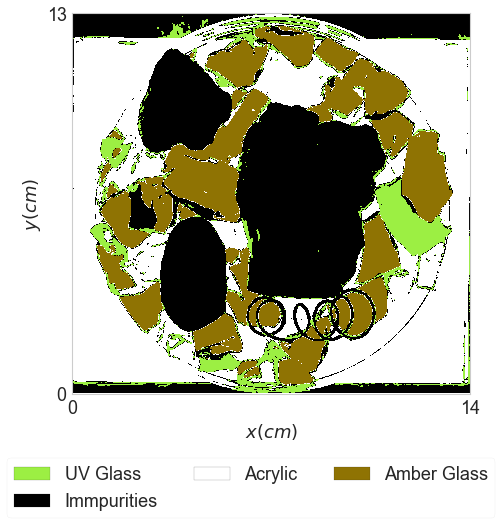

In [92]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
fig, ax = subplots(1, 1, figsize = (15, 7))

colors = ["xkcd:kiwi", "xkcd:black", "xkcd:white", "xkcd:poo"]
name_list = ["UV Glass", "Immpurities", "Acrylic", "Amber Glass"]
cmap = ListedColormap(colors)

hls = []
for color, cluster in zip(colors, name_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

axs = ax
axs.imshow(labels, cmap = cmap)
axs.grid(False)
axs.set_xticks([0, sample_image.shape[1]])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([sample_image.shape[0], 0])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)
axs.legend(handles = hls, loc = 'lower center',  bbox_to_anchor = (0.45, -0.35), ncol = 3, fontsize = 18)

In [101]:
img_areia = io.imread(r"D:/Data/Data_RGB/Glass/areia1.jpg")
data_img = img_areia.reshape(img_areia.shape[0]*img_areia.shape[1], -1)
scaled_areia = MinMaxScaler().fit_transform(data_img)
# scaled = data_img

model = GaussianMixture(n_components = 4, covariance_type = 'tied')
model.fit(scaled_areia)
labels = model.predict(scaled_areia).reshape(img_areia.shape[:2])

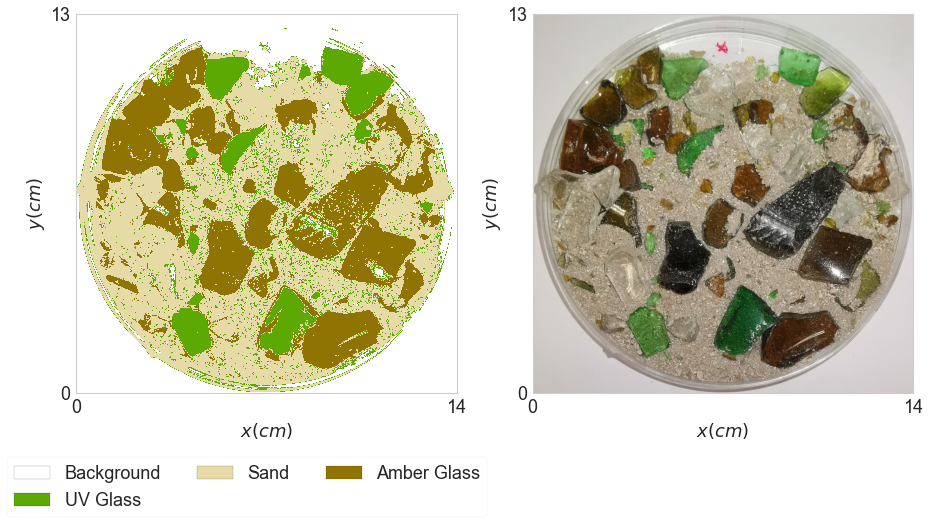

In [111]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
fig, ax = subplots(1, 2, figsize = (15, 7))

colors = ["xkcd:white", "xkcd:leaf green", "xkcd:beige", "xkcd:poo"]
name_list = ["Background", "UV Glass", "Sand", "Amber Glass"]
cmap = ListedColormap(colors)

hls = []
for color, cluster in zip(colors, name_list):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)

axs = ax[0]
axs.imshow(labels, cmap = cmap)
axs.grid(False)
axs.set_xticks([0, img_areia.shape[1]])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([img_areia.shape[0], 0])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)
axs.legend(handles = hls, loc = 'lower center',  bbox_to_anchor = (0.45, -0.35), ncol = 3, fontsize = 18)

axs = ax[1]
axs.imshow(img_areia, cmap = cmap)
axs.grid(False)
axs.set_xticks([0, img_areia.shape[1]])
axs.set_xticklabels([0, int(np.round(x_size))], fontsize = 18)
axs.set_yticks([img_areia.shape[0], 0])
axs.set_yticklabels([0, int(np.round(y_size))], fontsize = 18)
axs.set_xlabel(r'$x(cm)$', fontsize = 18)
axs.set_ylabel(r'$y(cm)$', fontsize = 18)
axs.grid(False)